References:

* [Step by Step Diabetes Classification-KNN-detailed )](https://www.kaggle.com/code/shrutimechlearn/step-by-step-diabetes-classification-knn-detailed)
- [Compare the effect of different scalers on data with outliers](https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html#plot-all-scaling-minmax-scaler-section)

#Load Data

In [ ]:
from matplotlib import rcParams
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


In [ ]:
# Load the dataset
df = pd.read_csv('drive/MyDrive/Completumhealth/diabetes/diabetes.csv')

# rename the DiabetesPedigreeFunction column
df.rename(columns ={"DiabetesPedigreeFunction":"DPF"},inplace=True)
feature_names = [cname for cname in df.loc[:,:'Age'].columns]

#Exploratory Data Analysis

In [ ]:
def compute_stat(df):
  # Column names
  columns = ['Feature','Mean', 'Std', 'Skewness','Kurtosis']
  df_stats = pd.DataFrame(columns=columns)

  for column in df.columns:
      mean = df[column].mean()
      std = df[column].std()
      skew = df[column].skew()
      kurtosis = df[column].kurtosis()
      df_stats.loc[len(df_stats)] = [column, mean,std,skew,kurtosis]
      #print(column+':')
      #print('mean: {0:.4f}, std: {1:.4f}, skew: {2:.4f}, kurtosis: {3:.4f} '.format(mean, std, skew, kurtosis))
  return df_stats

df_stats = compute_stat(df)
print(df_stats)

         Feature        Mean         Std  Skewness  Kurtosis
0    Pregnancies    3.845052    3.369578  0.901674  0.159220
1        Glucose  120.894531   31.972618  0.173754  0.640780
2  BloodPressure   69.105469   19.355807 -1.843608  5.180157
3  SkinThickness   20.536458   15.952218  0.109372 -0.520072
4        Insulin   79.799479  115.244002  2.272251  7.214260
5            BMI   31.992578    7.884160 -0.428982  3.290443
6            DPF    0.471876    0.331329  1.919911  5.594954
7            Age   33.240885   11.760232  1.129597  0.643159
8        Outcome    0.348958    0.476951  0.635017 -1.600930


In [ ]:
def kurtosis_warning(val):
  if -0.5 < val < 0.5:
    color = "green"
  if val > .5:
    color = 'blue'
  if val < -.5:
    color = "cyan"
  return f'color: {color}'

def skew_warning(val):
  if -0.5 < val < 0.5:
    color = "green"
  if -1 < val < -0.5 or 0.5 < val < 1:
    color = 'yellow'
  if val < -1 or val > 1:
    color = "red"
  return f'color: {color}'

df_styled = (df_stats.style.applymap(skew_warning, subset=['Skewness']).applymap(kurtosis_warning, subset=['Kurtosis']))
df_styled

,Feature,Mean,Std,Skewness,Kurtosis
0,Pregnancies,3.845052,3.369578,0.901674,0.159220
1,Glucose,120.894531,31.972618,0.173754,0.640780
2,BloodPressure,69.105469,19.355807,-1.843608,5.180157
3,SkinThickness,20.536458,15.952218,0.109372,-0.520072
4,Insulin,79.799479,115.244002,2.272251,7.214260
5,BMI,31.992578,7.884160,-0.428982,3.290443
6,DPF,0.471876,0.331329,1.919911,5.594954
7,Age,33.240885,11.760232,1.129597,0.643159
8,Outcome,0.348958,0.476951,0.635017,-1.600930


For Skewness:
* <font color="green">Green</font>: Fairly symmetrical.
* <font color="yellow">Yellow</font>: Moderate skewness.
* <font color="red">Red</font>: High skewness.

For Kurtosis:
* <font color="green">Green</font>: Similar to a normal distribution.
* <font color="blue">Blue</font>: More outliers than a normal distribution.
* <font color="cyan">Cyan</font>: Fewer outliers than a normal distribution.

Logically zero values do not make sense for most of the columns, they are effectively missing values. We shall replace the zero values with the mean or median values based on the distribution of data for the coressponding columns.  

Logically, pregnancies can be 0 hence we will not replace these zeros.

In [ ]:
# check proportion of zeros
zero_features = ['Glucose','BloodPressure','SkinThickness',"Insulin",'BMI']
total_count = df.shape[0]

print("Proportion of Zeros:")
for feature in zero_features:
    zero_count = df[df[feature]==0].shape[0]
    pcent = zero_count/total_count * 100
    print('{0}: {1}, {2:.2f}%'.format(feature, zero_count, pcent))

Proportion of Zeros:
Glucose: 5, 0.65%
BloodPressure: 35, 4.56%
SkinThickness: 227, 29.56%
Insulin: 374, 48.70%
BMI: 11, 1.43%


In [ ]:
# glucose is approximately normally distributed
mean = df["Glucose"].mean()
df["Glucose"].replace(0, mean, inplace=True)

# BloodPressure is approximately normally distributed
mean = df["BloodPressure"].mean()
df["BloodPressure"].replace(0, mean, inplace=True)

# SkinThickness is not normally distributed
median = df["SkinThickness"].median()
df["SkinThickness"].replace(0, median, inplace=True)

# Insulin is not normally distributed
median = df["Insulin"].median()
df["Insulin"].replace(0, median, inplace=True)

# BMI is approximately normally distributed
mean = df["BMI"].mean()
df["BMI"].replace(0, mean, inplace=True)



In [ ]:
def histplot(df):
  rcParams['figure.figsize'] = 40,60
  sns.set(font_scale = 3)
  sns.set_style("white")
  sns.set_palette("bright")
  plt.subplots_adjust(hspace=0.5)
  i = 1;
  for name in feature_names:
      plt.subplot(5,2,i)
      sns.histplot(data=df, x=name, hue="Outcome",kde=True,palette="YlGnBu")
      i = i + 1

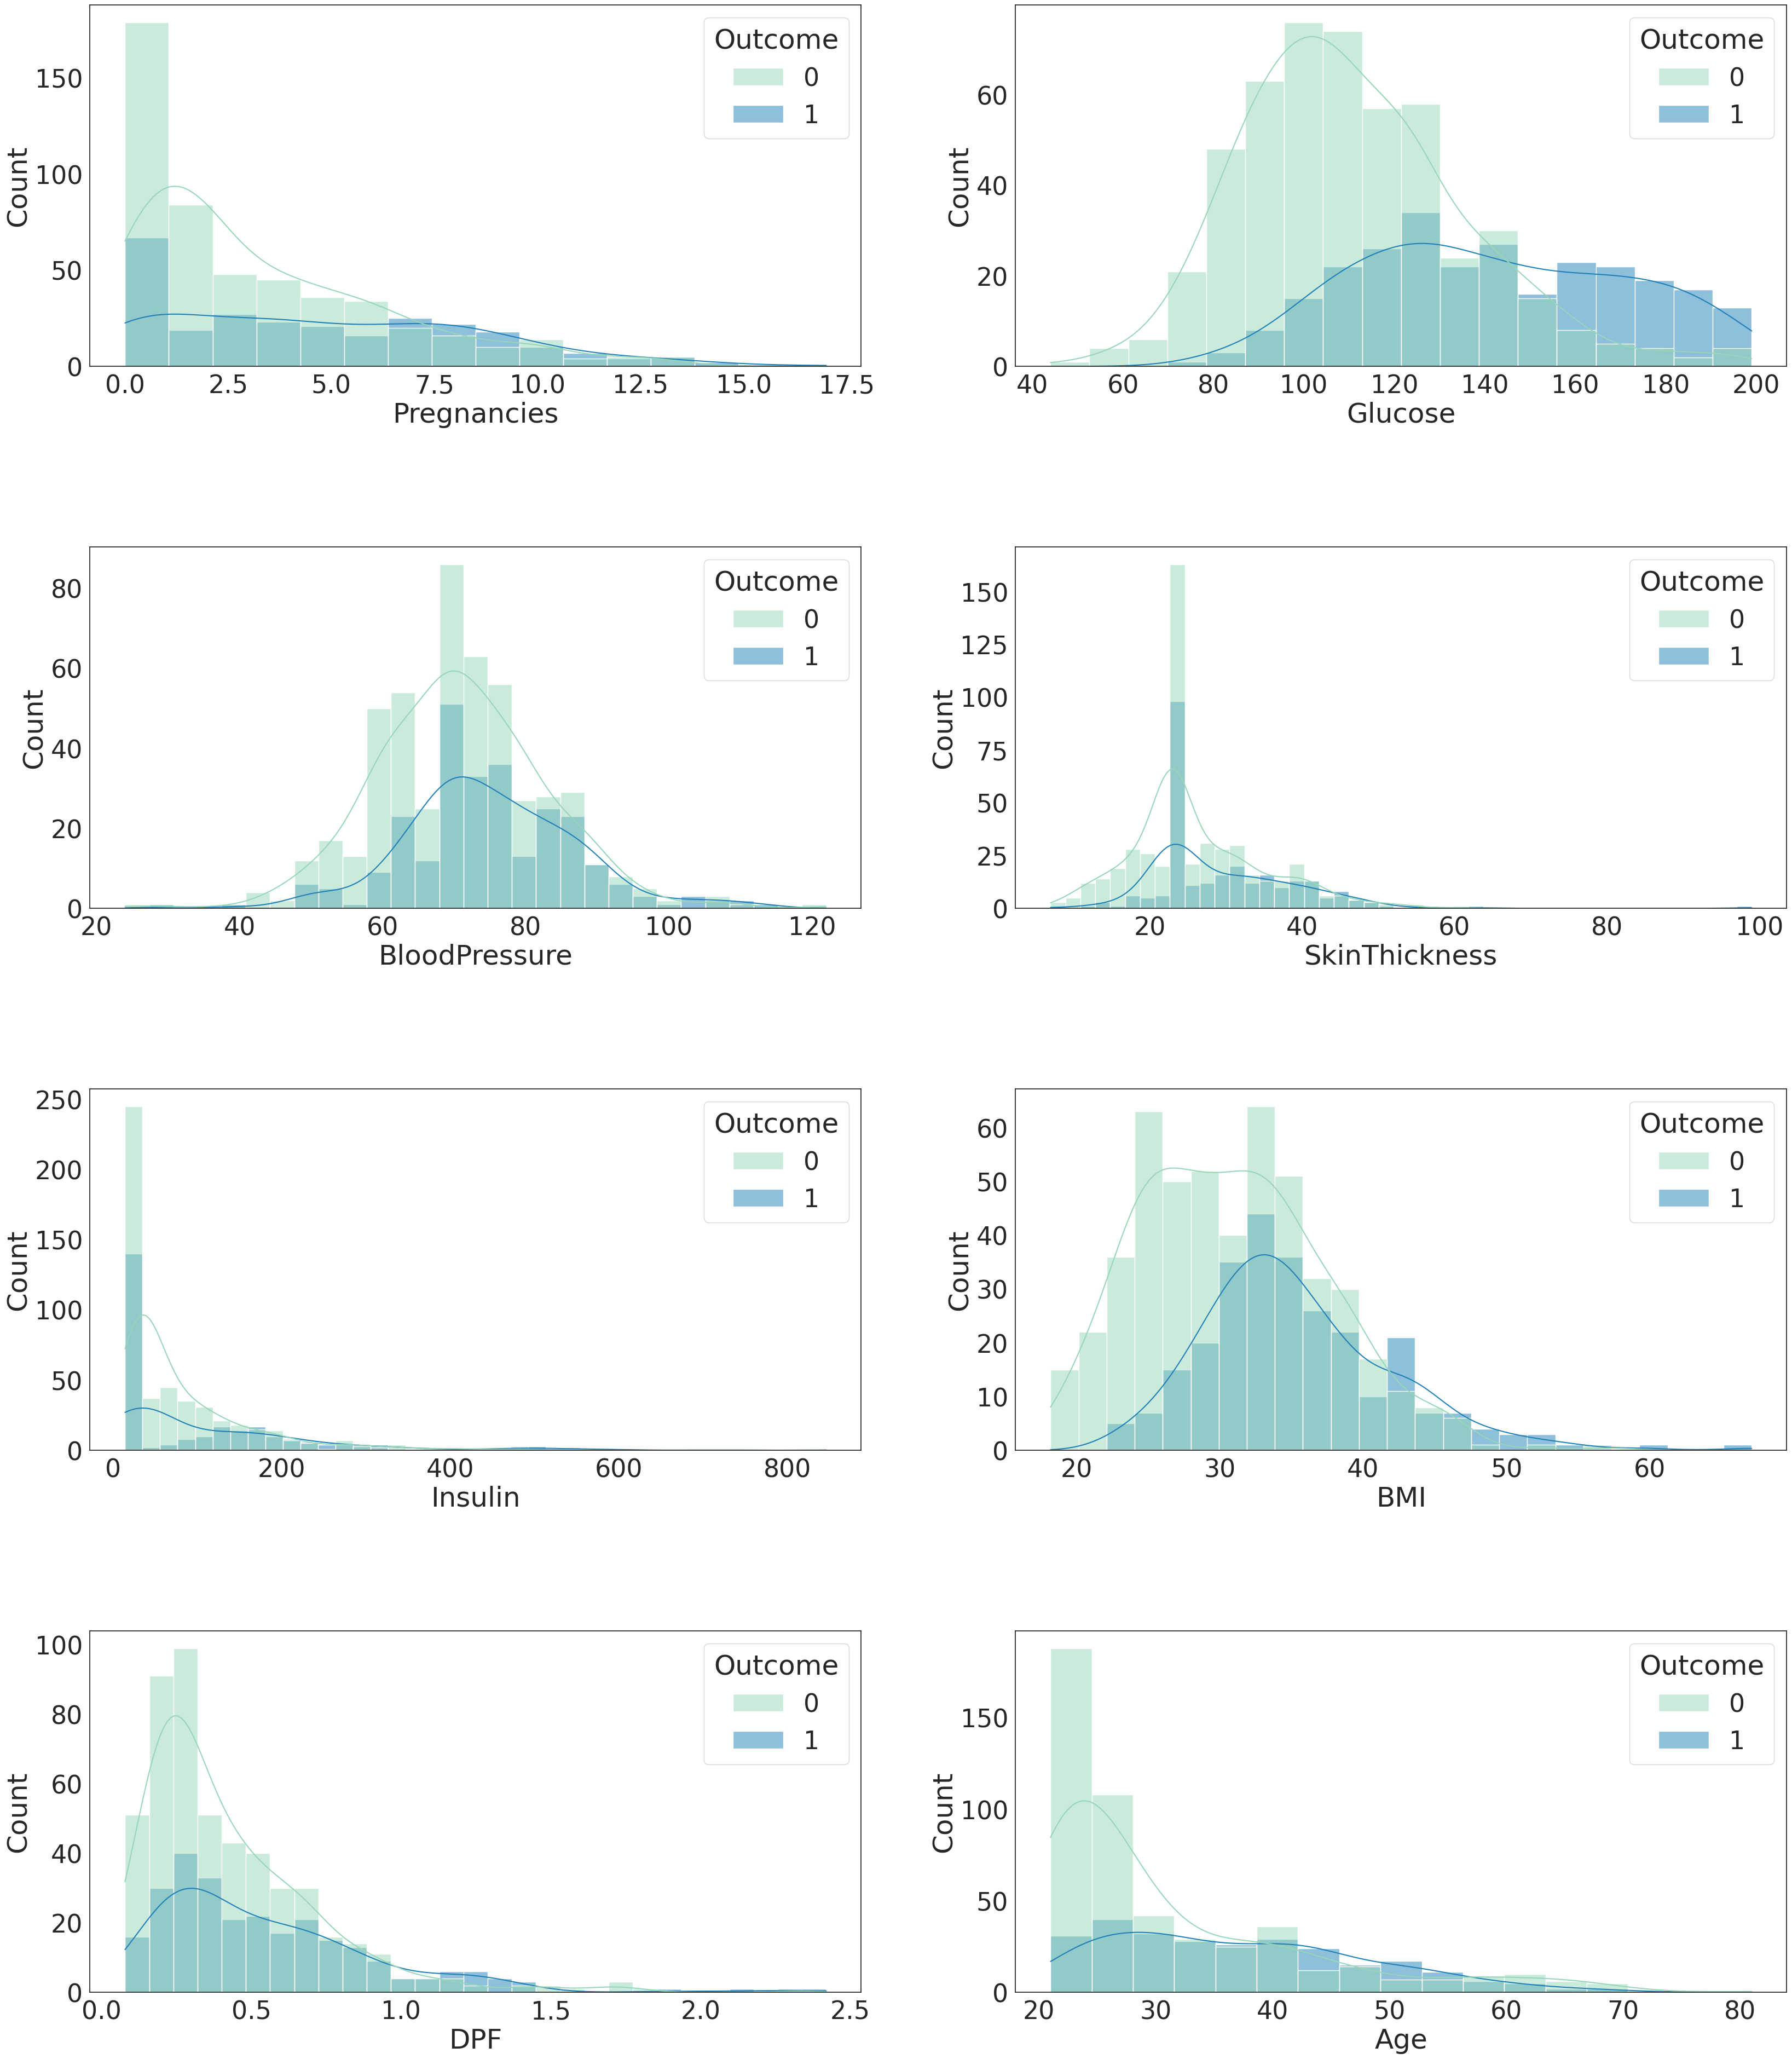

In [ ]:
histplot(df)

In [ ]:
df_stats2 = compute_stat(df)
df_styled2 = (df_stats2.style.applymap(skew_warning, subset=['Skewness']).applymap(kurtosis_warning, subset=['Kurtosis']))
df_styled2

,Feature,Mean,Std,Skewness,Kurtosis
0,Pregnancies,3.845052,3.369578,0.901674,0.159220
1,Glucose,121.681605,30.436016,0.533225,-0.258820
2,BloodPressure,72.254807,12.115932,0.173050,1.079233
3,SkinThickness,27.334635,9.229014,1.223057,4.716995
4,Insulin,94.652344,105.547598,2.693181,9.741075
5,BMI,32.450805,6.875374,0.601103,0.921318
6,DPF,0.471876,0.331329,1.919911,5.594954
7,Age,33.240885,11.760232,1.129597,0.643159
8,Outcome,0.348958,0.476951,0.635017,-1.600930


#Scaling

In [ ]:
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
df_scaled =  pd.DataFrame(sc_X.fit_transform(df.drop(["Outcome"],axis = 1),),
        columns=['Pregnancies', 'Glucose', 'BP', 'SkinThickness', 'Insulin','BMI', 'DPF', 'Age'])

In [ ]:
df_scaled.head()

,Pregnancies,Glucose,BP,SkinThickness,Insulin,BMI,DPF,Age
0,0.639947,0.865276,-0.021044,0.831114,-0.608201,0.167255,0.468492,1.425995
1,-0.844885,-1.205989,-0.516583,0.180566,-0.608201,-0.851535,-0.365061,-0.190672
2,1.233880,2.015979,-0.681762,-0.469981,-0.608201,-1.331821,0.604397,-0.105584
3,-0.844885,-1.074480,-0.516583,-0.469981,-0.006185,-0.633222,-0.920763,-1.041549
4,-1.141852,0.503626,-2.663916,0.831114,0.695378,1.549899,5.484909,-0.020496


In [ ]:
df_stats3 = compute_stat(df_scaled)
df_styled3 = (df_stats3.style.applymap(skew_warning, subset=['Skewness']).applymap(kurtosis_warning, subset=['Kurtosis']))
df_styled3

,Feature,Mean,Std,Skewness,Kurtosis
0,Pregnancies,-0.000000,1.000652,0.901674,0.159220
1,Glucose,-0.000000,1.000652,0.533225,-0.258820
2,BP,0.000000,1.000652,0.173050,1.079233
3,SkinThickness,-0.000000,1.000652,1.223057,4.716995
4,Insulin,0.000000,1.000652,2.693181,9.741075
5,BMI,-0.000000,1.000652,0.601103,0.921318
6,DPF,0.000000,1.000652,1.919911,5.594954
7,Age,0.000000,1.000652,1.129597,0.643159


# Custom Classifier



In [ ]:
from sklearn.model_selection import train_test_split


In [ ]:
# Split data into training and test sets
X = df.drop('Outcome', axis=1)
y = df['Outcome']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=44, stratify=y)


In [ ]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.neighbors import KNeighborsClassifier
import statistics as stats

class CustomClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, **kwargs):
        # call knn classifier
        self.knn = KNeighborsClassifier(**kwargs)
        self.X_train = pd.DataFrame()

    def fit(self, X, y=None):
        self.X_train = X.copy()
        return self.knn.fit(X,y)

    def __calculate_variance(self):
      class_labels = self.knn.predict(self.X_train)
      Xt_copy = self.X_train.copy()
      Xt_copy["Class"] = class_labels
      grouped = Xt_copy.groupby("Class")
      var_df = pd.DataFrame()


      for group_name, group_data in grouped:
        # calculate mean vector
        mean_vector = np.mean(group_data, axis=0)
        print(mean_vector)
        # calculate squared Euclidean distances
        squared_distances = np.sum((group_data - mean_vector)**2, axis=1)
        print("squared_distances:",squared_distances)
        # calculate variance
        variance = np.mean(squared_distances)
        print("variance:",variance)
        count = len(group_data)
        data = pd.DataFrame([count,variance])
        var_df[group_name] = data
      custom_row_names = ["Count","Variance"]
      var_df.index = custom_row_names

      return (var_df,mean)

    def __update_variance(self,var_df,mean,x):
      count = var_df.loc["Count"]
      var_old = var_df.loc["Variance"]
      new_var = []
      for idx in range(len(count)):
        n = count[idx]
        n_new = n + 1
        squared_distances = np.sum((x - mean[idx])**2)
        var_new = (n / n_new) * var_old[idx] + (1 / n_new) * squared_distances
        new_var.append(var_new)

      new_row = pd.Series(new_var, index=var_df.columns)
      var_df = var_df.append(new_row, ignore_index=True)
      #var_df = var_df.rename(index={df.index[-1]: 'New Variance'})
      return var_df

    def predict(self, X, y=None):
        var_df,mean = self.__calculate_variance()

        for idx,row in X.iterrows():
          var_df = self.__update_variance(var_df,mean,row)
          custom_row_names = ["Count","Variance","New Variance"]
          var_df.index = custom_row_names
          print(var_df)
          input("Press enter to continue")

    def predict_proba(self,X,y=None):
        pass

# Create and train the custom classifier
custom_classifier = CustomClassifier()
custom_classifier.fit(X_train, y_train)

# Make predictions
custom_classifier.predict(X_test)

# Evaluate the classifier
#accuracy = (predictions == y_test).mean()
#print(f"Accuracy: {accuracy:.2f}")


squared_distances: 442     1813.358162
556     2793.282720
550     2628.181838
223    14362.569679
94      1768.407753
           ...     
745     1205.594604
671     3073.125942
383      973.439356
282     6768.547412
520     1890.393952
Length: 392, dtype: float64
variance: 6245.176398315278
squared_distances: 540     10419.482572
155      9930.829312
386     10530.409559
206     25878.583177
641     10078.712904
           ...      
584    224609.674143
690     11417.824581
495     10560.526952
167     10397.252849
613     11546.566509
Length: 184, dtype: float64
variance: 18291.852356949334


IndexError: ignored

In [ ]:
## score that comes from testing on the same datapoints that were used for training
max_train_score = max(train_scores)
train_scores_ind = [i for i, v in enumerate(train_scores) if v == max_train_score]
print('Max train score {} % and k = {}'.format(max_train_score*100,list(map(lambda x: x+1, train_scores_ind))))

Max train score 100.0 % and k = [1]


In [ ]:
# score that comes from testing on the datapoints that were split in the beginning to be used for testing solely
max_test_score = max(test_scores)
test_scores_ind = [i for i, v in enumerate(test_scores) if v == max_test_score]
print('Max test score {} % and k = {}'.format(max_test_score*100,list(map(lambda x: x+1, test_scores_ind))))

Max test score 71.875 % and k = [10]


# Visualization

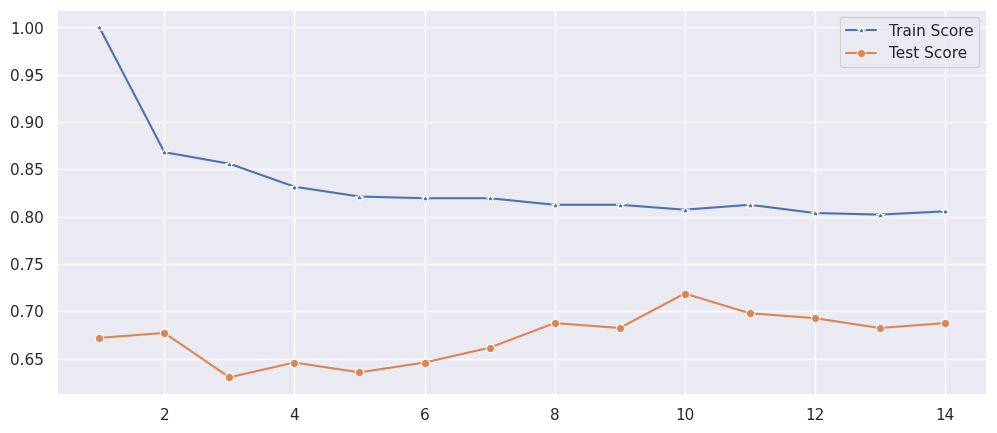

In [ ]:
import seaborn as sns
sns.set()
plt.figure(figsize=(12,5))
p = sns.lineplot(x=range(1,15),y=train_scores,marker='*',label='Train Score')
p = sns.lineplot(x=range(1,15),y=test_scores,marker='o',label='Test Score')

The best result was obtained at k = 10 hence, 10 will be used for the final KNN classifier model.

In [ ]:
#Setup a knn classifier with k neighbors
knn = KNeighborsClassifier(10)

knn.fit(X_train,y_train)
knn.score(X_test,y_test)

0.71875

**Confusion Matrix**

In [ ]:
#prediction
pred = knn.predict(X_test)
pred_proba = knn.predict_proba(X_test)[:,1]


Text(0.5, 1.0, 'Confusion Matrix (Stacking)')

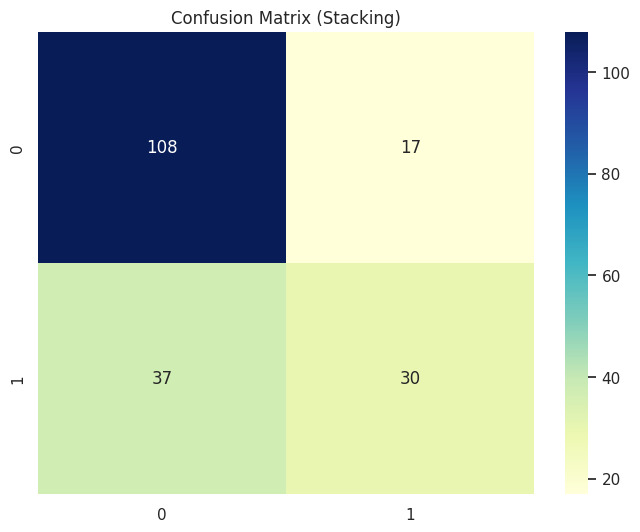

In [ ]:
from sklearn.metrics import confusion_matrix

plt.figure(figsize=(8, 6))

y_pred = knn.predict(X_test)
confusion = confusion_matrix( y_test, y_pred)
ax = sns.heatmap(confusion, cmap = 'YlGnBu',annot = True, fmt='d')
ax.set_title('Confusion Matrix (Stacking)')

In [ ]:
from sklearn.metrics import roc_curve
y_pred_proba = knn.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

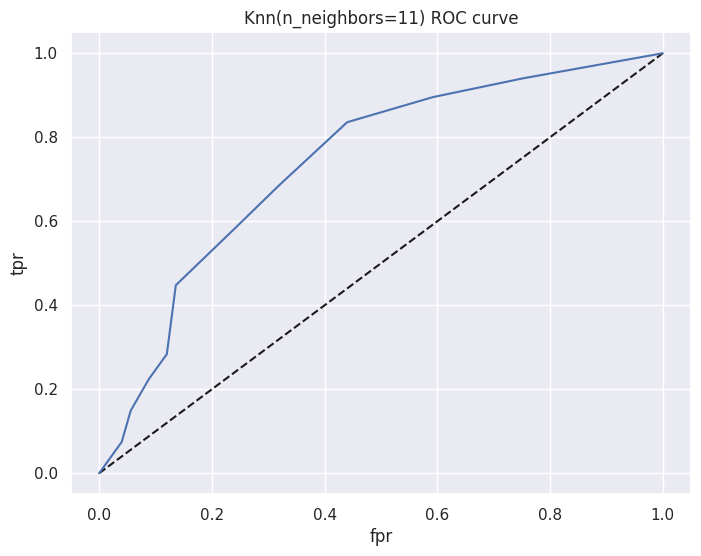

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr,tpr, label='Knn')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('Knn(n_neighbors=11) ROC curve')
plt.show()

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.74      0.86      0.80       125
           1       0.64      0.45      0.53        67

    accuracy                           0.72       192
   macro avg       0.69      0.66      0.66       192
weighted avg       0.71      0.72      0.70       192



In [ ]:
#import GridSearchCV
from sklearn.model_selection import GridSearchCV
#In case of classifier like knn the parameter to be tuned is n_neighbors
param_grid = {'n_neighbors':np.arange(1,50)}
knn = KNeighborsClassifier()
knn_cv= GridSearchCV(knn,param_grid,cv=5)
knn_cv.fit(X,y)

print("Best Score:" + str(knn_cv.best_score_))
print("Best Parameters: " + str(knn_cv.best_params_))

Best Score:0.753968253968254
Best Parameters: {'n_neighbors': 34}
